##Decoder Only Transformer

In [ ]:
import pandas as pd
import torch
import torch.nn as nn
from torch.nn import functional as F


# hyperparameters
batch_size = 16 # how many independent sequences will we process in parallel?
block_size = 32 # what is the maximum context length for predictions?
max_iters = 5000
eval_interval = 100
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 64
n_head = 4
n_layer = 4
dropout = 0.0

In [ ]:
torch.manual_seed(1337)

n_features = 1

# data loading
def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B,T,C = x.shape
        k = self.key(x)   # (B,T,C)
        q = self.query(x) # (B,T,C)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * C**-0.5 # (B, T, C) @ (B, C, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,C)
        out = wei @ v # (B, T, T) @ (B, T, C) -> (B, T, C)
        return out

class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

# super simple bigram model
class TimeSeriesTransformer(nn.Module):

    def __init__(self):
        super().__init__()
        self.input_projection = nn.Linear(n_features, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd) # final layer norm
        self.lm_head = nn.Linear(n_embd, n_features)

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        # print(idx.shape)
        inp_emb = self.input_projection(idx.unsqueeze(-1)) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = inp_emb + pos_emb # (B,T,C)
        x = self.blocks(x) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        preds = self.lm_head(x) # (B,T,n_features)

        if targets is None:
            loss = None
        else:
            B, T, C = preds.shape
            preds = preds.view(B*T, C).squeeze(-1)
            targets = targets.view(B*T)
            loss = F.mse_loss(preds, targets)

        return preds, loss


###IBM Data



In [ ]:
def get_ibm():
  # Read the CSV file using pandas
  data_frame = pd.read_csv('ibm.csv')

  # Get the values from the first column as a NumPy array
  column_values = data_frame.iloc[:, 1].values

  # Convert the NumPy array to a Torch tensor
  tensor = torch.tensor(column_values, dtype=torch.float32)

  n = int(0.9*len(tensor)) # first 90% will be train, rest val
  train_data = tensor[:n]
  val_data = tensor[n:]

  train_data = torch.nan_to_num(train_data, nan=torch.nanmean(train_data))
  val_data = torch.nan_to_num(val_data, nan=torch.nanmean(train_data))
  return train_data, val_data


In [ ]:
train_data, val_data = get_ibm()

model = TimeSeriesTransformer()
m = model.to(device)
# print the number of parameters in the model
print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')

# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)


for iter in range(max_iters):
    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss()
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}, "
        f"ratio = {losses['val']/losses['train']:.4f}")

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

0.201537 M parameters
step 0: train loss 22051.3145, val loss 24987.2305, ratio = 1.1331
step 100: train loss 19053.9531, val loss 21738.8105, ratio = 1.1409
step 200: train loss 15859.9854, val loss 18176.9688, ratio = 1.1461
step 300: train loss 12176.5000, val loss 13832.5762, ratio = 1.1360
step 400: train loss 8283.2930, val loss 9430.7510, ratio = 1.1385
step 500: train loss 5358.9438, val loss 5813.9023, ratio = 1.0849
step 600: train loss 3234.5957, val loss 3250.8452, ratio = 1.0050
step 700: train loss 1889.2433, val loss 1623.4990, ratio = 0.8593
step 800: train loss 1170.7299, val loss 709.4730, ratio = 0.6060
step 900: train loss 622.8817, val loss 257.7914, ratio = 0.4139
step 1000: train loss 383.4491, val loss 84.2911, ratio = 0.2198
step 1100: train loss 216.8854, val loss 26.7311, ratio = 0.1232
step 1200: train loss 129.4057, val loss 7.9435, ratio = 0.0614
step 1300: train loss 84.9176, val loss 2.9215, ratio = 0.0344
step 1400: train loss 53.6297, val loss 2.4027, 

###All Stocks

In [ ]:
def get_stocks():
  # Read the CSV file using pandas
  data_frame = pd.read_csv('alL_stocks.csv')

  grouped_data = data_frame.groupby("Name")

  train_data = torch.tensor([], dtype=torch.float32)
  val_data = torch.tensor([], dtype=torch.float32)

  for name, data in grouped_data:
      column_values = data.iloc[:, 1].values
      column_tensor = torch.tensor(column_values, dtype=torch.float32)
      train_data = torch.cat((train_data, column_tensor[:round(0.9*len(column_tensor))]), dim=0)
      val_data = torch.cat((val_data, column_tensor[round(0.9*len(column_tensor)):]), dim=0)

In [ ]:
train_data, val_data = get_stocks()

# Print the shapes of train_data and val_data
print(train_data.dtype, val_data.dtype)

train_data = torch.nan_to_num(train_data, nan=torch.nanmean(train_data))
val_data = torch.nan_to_num(val_data, nan=torch.nanmean(train_data))

model = TimeSeriesTransformer()
m = model.to(device)
# print the number of parameters in the model
print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')

# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)


for iter in range(max_iters):
    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss()
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}, "
        f"ratio = {losses['val']/losses['train']:.4f}")

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

torch.float32 torch.float32
0.201537 M parameters
step 0: train loss 13763.6133, val loss 69074.0156, ratio = 5.0186
step 100: train loss 13659.7275, val loss 65877.6328, ratio = 4.8228
step 200: train loss 10997.9248, val loss 60546.7617, ratio = 5.5053
step 300: train loss 8799.7471, val loss 58204.6758, ratio = 6.6144
step 400: train loss 7204.4004, val loss 46716.8008, ratio = 6.4845
step 500: train loss 6027.0952, val loss 49978.0312, ratio = 8.2922
step 600: train loss 6050.4663, val loss 49956.2734, ratio = 8.2566
step 700: train loss 5340.0723, val loss 44151.6094, ratio = 8.2680
step 800: train loss 3782.3040, val loss 45353.2031, ratio = 11.9909
step 900: train loss 4294.6426, val loss 43181.9805, ratio = 10.0548
step 1000: train loss 3948.9368, val loss 38095.3164, ratio = 9.6470
step 1100: train loss 4493.6323, val loss 39472.7383, ratio = 8.7841
step 1200: train loss 3274.9143, val loss 31777.8242, ratio = 9.7034
step 1300: train loss 3556.3269, val loss 38174.2461, ratio 

###Influenza

In [ ]:
def get_ili():
  # Read the CSV file using pandas
  data_frame = pd.read_csv('ILI.csv')
  data_frame.rename(columns={'Unnamed: 3':'ratio'}, inplace=True )
  nonvalues = data_frame[data_frame['ratio']=='X'].index
  data_frame.drop(nonvalues, inplace=True)
  column_values = pd.to_numeric(data_frame.iloc[:, 3]).values
  tensor = torch.tensor(column_values, dtype=torch.float32)
  n = int(0.9*len(tensor)) # first 90% will be train, rest val
  train_data = tensor[:n]
  val_data = tensor[n:]
  return train_data, val_data

In [ ]:
train_data, val_data = get_ili()
model = TimeSeriesTransformer()
m = model.to(device)
# print the number of parameters in the model
print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')

# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

for iter in range(max_iters):
    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss()
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

0.201537 M parameters
step 0: train loss 5.7140, val loss 3.2296
step 100: train loss 0.6781, val loss 0.3018
step 200: train loss 0.5219, val loss 0.3017
step 300: train loss 0.4844, val loss 0.3042
step 400: train loss 0.4671, val loss 0.2742
step 500: train loss 0.4581, val loss 0.2741
step 600: train loss 0.4312, val loss 0.2767
step 700: train loss 0.4712, val loss 0.2619
step 800: train loss 0.4509, val loss 0.2904
step 900: train loss 0.4290, val loss 0.2675
step 1000: train loss 0.4470, val loss 0.2793
step 1100: train loss 0.4291, val loss 0.2734
step 1200: train loss 0.4636, val loss 0.2766
step 1300: train loss 0.4292, val loss 0.2734
step 1400: train loss 0.4556, val loss 0.2814
step 1500: train loss 0.4236, val loss 0.2884
step 1600: train loss 0.4328, val loss 0.2714
step 1700: train loss 0.4498, val loss 0.2696
step 1800: train loss 0.4412, val loss 0.2643
step 1900: train loss 0.4452, val loss 0.2897
step 2000: train loss 0.4220, val loss 0.2591
step 2100: train loss 0.

###Attention exploraiton

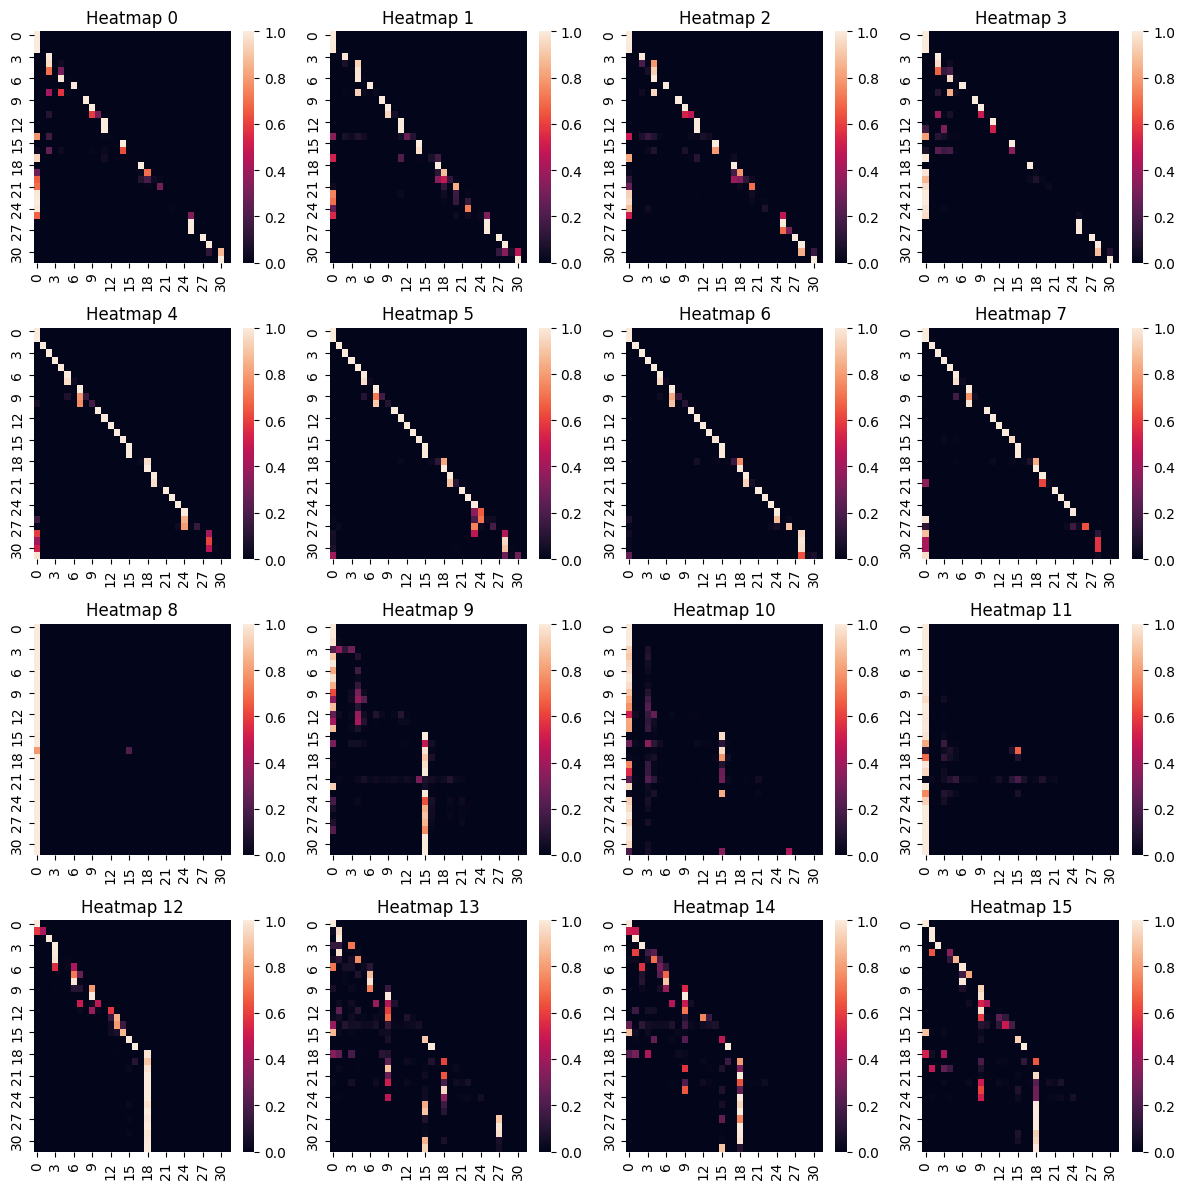

In [ ]:
macro_ex, _ = get_batch('eval')
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(12, 12))  # Grid size is 4x4

for i, ax in enumerate(axes.flatten()):
    mini_ex = macro_ex[i%4+4].unsqueeze(-1)
    emb = model.input_projection(mini_ex)
    pos = model.position_embedding_table(torch.arange(32, device=device))
    mini_ex = emb + pos
    keys = model.blocks[0].sa.heads[math.floor(i/4)].key(mini_ex)
    queries = model.blocks[0].sa.heads[math.floor(i/4)].query(mini_ex)
    wei = queries @ keys.transpose(-2,-1) * 8**-0.5
    wei = wei.cpu().detach()
    trill = torch.tril(torch.ones(block_size, block_size))
    wei = wei.masked_fill(trill[:32, :32] == 0, float('-inf'))
    wei = F.softmax(wei, dim=-1) # (B, T, T)
    sns.heatmap(wei, ax=ax)  # Set heatmap color to orange
    ax.set_title(f'Heatmap {i}')

plt.tight_layout()
plt.show()

##First attempt at an Encoder Decoder

In [ ]:
import pandas as pd
import torch
import torch.nn as nn
from torch.nn import functional as F

# hyperparameters
batch_size = 16 # how many independent sequences will we process in parallel?
block_size = 32 # what is the maximum context length for predictions?
max_iters = 5000
eval_interval = 100
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 64
n_head = 4
n_layer = 4
dropout = 0.0
# ------------

torch.manual_seed(1337)

n_features = 1

# data loading
def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    if split == 'dist':
      data = dist_data
    elif split == 'pres':
      data = pres_data
    else:
      data =val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['dist', 'pres', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, _ = get_batch('dist')
            xb, yb = get_batch(split)
            logits, loss = model(X, xb, yb)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out


In [ ]:
class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

In [ ]:
class DecoderBlock(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size, mask=True)
        self.ca = MultiHeadAttention(n_head, head_size, mask=False)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)
        self.ln3 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ca(self.ln2(x))
        x = x + self.ffwd(self.ln3(x))
        return x

    def load_kvs(self, ks, vs):
        self.ca.set_keys(ks)
        self.ca.set_values(vs)

In [ ]:
class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size, mask, loaded=False, key=None, value=None):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))
        self.mask = mask
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B,T,C = x.shape
        k = self.key(x)   # (B,T,C)
        q = self.query(x) # (B,T,C)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * C**-0.5 # (B, T, C) @ (B, C, T) -> (B, T, T)
        if self.mask == True:
          wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,C)
        out = wei @ v # (B, T, T) @ (B, T, C) -> (B, T, C)
        return out

class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size, mask=True):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size, mask=mask) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

    def get_keys(self):
        return [h.key for h in self.heads]

    def get_values(self):
        return [h.value for h in self.heads]

    def set_keys(self, ks):
        for i, h in enumerate(self.heads):
          h.key = ks[i]

    def set_values(self, vs):
        for i, h in enumerate(self.heads):
          h.value = vs[i]

class EncoderBlock(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size, mask=False)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

    def get_keys(self):
        return self.sa.get_keys()

    def get_values(self):
        return self.sa.get_values()


In [ ]:
class TimeSeriesTransformer(nn.Module):
    def __init__(self):
        super().__init__()
        self.input_projection = nn.Linear(n_features, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.input_projection2 = nn.Linear(n_features, n_embd)
        self.position_embedding_table2 = nn.Embedding(block_size, n_embd)
        self.encoder_blocks = nn.Sequential(*[EncoderBlock(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.decoder_blocks = nn.Sequential(*[DecoderBlock(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd) # final layer norm
        self.lm_head = nn.Linear(n_embd, n_features)

    def forward(self, idx, idy, targets=None):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        # print(idx.shape)
        inp_emb = self.input_projection(idx.unsqueeze(-1)) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = inp_emb + pos_emb # (B,T,C)

        x = self.encoder_blocks(x) # (B,T,C)
        ks = self.encoder_blocks[-1].get_keys()
        vs = self.encoder_blocks[-1].get_values()
        self.decoder_blocks.load_kvs = (ks, vs)

        inp_emb2 = self.input_projection2(idy.unsqueeze(-1)) # (B,T,C)
        pos_emb2 = self.position_embedding_table2(torch.arange(T, device=device)) # (T,C)

        y = inp_emb2 + pos_emb2 # (B,T,C)
        y = self.decoder_blocks(y)

        y = self.ln_f(y) # (B,T,C)
        preds = self.lm_head(y) # (B,T,n_features)

        if targets is None:
            loss = None
        else:
            B, T, C = preds.shape
            preds = preds.view(B*T, C).squeeze(-1)
            targets = targets.view(B*T)
            loss = F.mse_loss(preds, targets)

        return preds, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            output, loss = self(idx_cond)
            # focus only on the last time step
            idx_next = logits[:, -1, :] # becomes (B, n_feautues = 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx


###Influenza

In [ ]:
data_frame = pd.read_csv('ILI.csv')
dist_data = torch.tensor([], dtype=torch.float32)
pres_data = torch.tensor([], dtype=torch.float32)
val_data = torch.tensor([], dtype=torch.float32)

group = data_frame.groupby('Unnamed: 0')
for name, data in group:
    column_values = data.iloc[:, 3].values
    column_tensor = torch.tensor(column_values, dtype=torch.float32)
    dist_data = torch.cat((dist_data, column_tensor[:round(0.6*len(column_tensor))]), dim=0)
    pres_data = torch.cat((pres_data, column_tensor[round(0.6*len(column_tensor)):round(0.9*len(column_tensor))]), dim=0)
    val_data = torch.cat((val_data, column_tensor[round(0.9*len(column_tensor)):]), dim=0)


In [ ]:
model = TimeSeriesTransformer()
m = model.to(device)
# print the number of parameters in the model
print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')

# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

for iter in range(max_iters):
    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss()
        print(f"step {iter}: dist loss {losses['dist']:.4f}, pres loss {losses['pres']:.4f},val loss {losses['val']:.4f}")

    # sample a batch of data
    xdist, _ = get_batch('dist')
    xpres, ypres = get_batch('pres')

    # evaluate the loss
    logits, loss = model(xdist, xpres, ypres)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

0.469185 M parameters
step 0: dist loss 6.1628, pres loss 10.6763,val loss 9.6536
step 100: dist loss 0.4342, pres loss 0.7618,val loss 1.0517
step 200: dist loss 0.4243, pres loss 0.6038,val loss 0.9769
step 300: dist loss 0.3522, pres loss 0.5605,val loss 0.8751
step 400: dist loss 0.3297, pres loss 0.4541,val loss 0.8050
step 500: dist loss 0.2708, pres loss 0.3993,val loss 0.6934
step 600: dist loss 0.2734, pres loss 0.3759,val loss 0.6696
step 700: dist loss 0.2552, pres loss 0.3239,val loss 0.6095
step 800: dist loss 0.1886, pres loss 0.2617,val loss 0.5067
step 900: dist loss 0.1510, pres loss 0.1828,val loss 0.3916
step 1000: dist loss 0.1097, pres loss 0.1330,val loss 0.3031
step 1100: dist loss 0.0719, pres loss 0.1031,val loss 0.2177
step 1200: dist loss 0.0495, pres loss 0.0699,val loss 0.1446
step 1300: dist loss 0.0433, pres loss 0.0572,val loss 0.1112
step 1400: dist loss 0.0417, pres loss 0.0524,val loss 0.0932
step 1500: dist loss 0.0288, pres loss 0.0344,val loss 0.07

##Second attempt at an Encoder Decoder

In [ ]:
import pandas as pd
import torch
import torch.nn as nn
from torch.nn import functional as F
import math

# hyperparameters
batch_size = 16 # how many independent sequences will we process in parallel?
block_size_src = 16 # what is the maximum context length for predictions?
block_size_tgt = block_size_src-1
max_iters = 5000
eval_interval = 100
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 32
n_head = 4
n_layer = 2
dropout = 0.0
n_features = 1
# ------------


###Utils

In [ ]:
# data loading
def get_batch_en_de(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(low=block_size_src, high=len(data)-block_size_tgt, size=(batch_size,))

    src = torch.stack([data[i-block_size_src+1:i+1] for i in ix])
    tgt = torch.stack([data[i:i+block_size_tgt] for i in ix])
    tgt_y = torch.stack([data[i+1:i+block_size_tgt+1] for i in ix])
    src, tgt, tgt_y = src.to(device), tgt.to(device), tgt_y.to(device)
    return src, tgt, tgt_y

@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            src, tgt, tgt_y = get_batch_en_de(split)
            _, loss = model(src, tgt, tgt_y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

###Architecture

In [ ]:
class TimeSeriesTransformer(nn.Module):

    def __init__(self):
        super().__init__()
        self.src_input_projection = nn.Linear(n_features, n_embd)
        self.tgt_input_projection = nn.Linear(n_features, n_embd)
        self.position_embedding_table = nn.Embedding(block_size_src, n_embd)
        self.encoder_blocks = nn.Sequential(*[EncoderBlock(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.decoder_blocks = nn.Sequential(*[DecoderBlock(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd) # final layer norm
        self.lm_head = nn.Linear(n_embd, n_features)

    def forward(self, src, tgt, tgt_y=None):
        B, T = src.shape
        # idx and targets are both (B,T) tensor of floats
        src_inp_emb = self.src_input_projection(src.unsqueeze(-1)) # (B,T,C)
        src_pos_emb = self.position_embedding_table(torch.arange(block_size_src, device=device)) # (T,C)
        src = src_inp_emb + src_pos_emb # (B,T,C)
        mem = self.encoder_blocks(src) # (B,T,C)

        tgt_inp_emb = self.tgt_input_projection(tgt.unsqueeze(-1)) # (B,T,C)
        tgt_pos_emb = self.position_embedding_table(torch.arange(block_size_tgt, device=device))
        tgt = tgt_inp_emb + tgt_pos_emb # (B,T,C)

        mem, out = self.decoder_blocks((mem, tgt)) # (B,T,C)
        out = self.ln_f(out) # (B,T,C)

        preds = self.lm_head(out) # (B,T,n_features)

        if tgt_y is None:
            loss = None
        else:
            B, T, C = preds.shape
            preds = preds.view(B*T, C).squeeze(-1)
            tgt_y = tgt_y.view(B*T)
            loss = F.mse_loss(preds, tgt_y)

        return preds, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            output, loss = self(idx_cond)
            # focus only on the last time step
            idx_next = logits[:, -1, :] # becomes (B, n_feautues = 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx


###Attentions

In [ ]:
torch.manual_seed(1337)
class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size, mask=True):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size_src, block_size_src)))
        self.mask = mask
        self.dropout = nn.Dropout(dropout)

    def forward(self, qsrc, ksrc, vsrc):
        B,T,C = qsrc.shape
        k = self.key(ksrc)   # (B,T,C)
        q = self.query(qsrc) # (B,T,C)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * C**-0.5 # (B, T, C) @ (B, C, T) -> (B, T, T)
        if self.mask:
          wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(vsrc) # (B,T,C)
        out = wei @ v # (B, T, T) @ (B, T, C) -> (B, T, C)
        return out

class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size, mask=True):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size, mask) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, qsrc, ksrc, vsrc):
        out = torch.cat([h(qsrc, ksrc, vsrc) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

###Feedword

In [ ]:
class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)


###Encoder

In [ ]:
class EncoderBlock(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        assert n_embd % n_head == 0, "n_embd should be devisible by n_head"
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size, mask=False)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = self.ln1(x)
        x = x + self.sa(x, x, x)
        x = self.ln2(x)
        x = x + self.ffwd(x)
        return x


###Decoder

In [ ]:
class DecoderBlock(nn.Module):
    """ Transformer block: communication followed by computation """
    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        assert n_embd % n_head == 0, "n_embd should be devisible by n_head"
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size, mask=True)
        self.ca = MultiHeadAttention(n_head, head_size, mask=False)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)
        self.ln3 = nn.LayerNorm(n_embd)

    def forward(self, mem_and_tgt):
        mem, tgt = mem_and_tgt
        tgt = self.ln1(tgt)
        tgt = tgt + self.sa(tgt, tgt, tgt)
        tgt = self.ln2(tgt)
        tgt = tgt + self.ca(tgt, mem, mem)
        tgt = self.ln3(tgt)
        tgt = tgt + self.ffwd(tgt)
        return (mem, tgt)


####IBM

In [ ]:
train_data, val_data = get_ibm()
model = TimeSeriesTransformer()
m = model.to(device)
# print the number of parameters in the model
print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')

# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)


for iter in range(max_iters):
    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss()
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    # sample a batch of data
    src, tgt, tgt_y = get_batch_en_de('train')

    # evaluate the loss
    pr, loss = model(src, tgt, tgt_y)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

0.059553 M parameters
step 0: train loss 22655.1797, val loss 25853.4551
step 100: train loss 20182.5195, val loss 22914.6504
step 200: train loss 18468.7656, val loss 20906.3906
step 300: train loss 16265.1611, val loss 18258.4004
step 400: train loss 13632.2334, val loss 15293.4092
step 500: train loss 10419.7578, val loss 12310.6348
step 600: train loss 8200.1787, val loss 9240.1523
step 700: train loss 6110.6650, val loss 6728.7642
step 800: train loss 4446.0649, val loss 4684.8276
step 900: train loss 3327.4810, val loss 3195.3281
step 1000: train loss 2348.3530, val loss 2071.5635
step 1100: train loss 1977.2445, val loss 1304.7117
step 1200: train loss 1721.0239, val loss 895.8351
step 1300: train loss 1585.6846, val loss 664.5287
step 1400: train loss 1601.5710, val loss 542.3583
step 1500: train loss 1541.4474, val loss 459.2493
step 1600: train loss 1520.4163, val loss 451.5602
step 1700: train loss 1514.2131, val loss 375.7295
step 1800: train loss 1503.6154, val loss 371.50

KeyboardInterrupt: ignored

####Influenza

In [ ]:
train_data, val_data = get_ili()
model = TimeSeriesTransformer()
m = model.to(device)
# print the number of parameters in the model
print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')

# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)


for iter in range(1500):
    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss()
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    # sample a batch of data
    src, tgt, tgt_y = get_batch_en_de('train')

    # evaluate the loss
    pr, loss = model(src, tgt, tgt_y)
    # if iter % eval_interval == 0:
      # print('\nSOURCE---------\n', src, '\nTARGET------\n', tgt, '\nTARGET_Y-------\n', tgt_y)
      # print('\nSOURCE---------\n', pr)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

0.059553 M parameters
step 0: train loss 8.1377, val loss 4.9452
step 100: train loss 1.1194, val loss 0.4170
step 200: train loss 0.6690, val loss 0.3348
step 300: train loss 0.5821, val loss 0.2832
step 400: train loss 0.6438, val loss 0.3443
step 500: train loss 0.5149, val loss 0.2888
step 600: train loss 0.4394, val loss 0.2804
step 700: train loss 0.6090, val loss 0.4071
step 800: train loss 0.4500, val loss 0.2900
step 900: train loss 0.4947, val loss 0.3089
step 1000: train loss 0.4391, val loss 0.2854
step 1100: train loss 0.4655, val loss 0.2767
step 1200: train loss 0.5329, val loss 0.3882
step 1300: train loss 0.4618, val loss 0.2712
step 1400: train loss 0.4409, val loss 0.2872


###Attention exploration

####Encoder attention

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

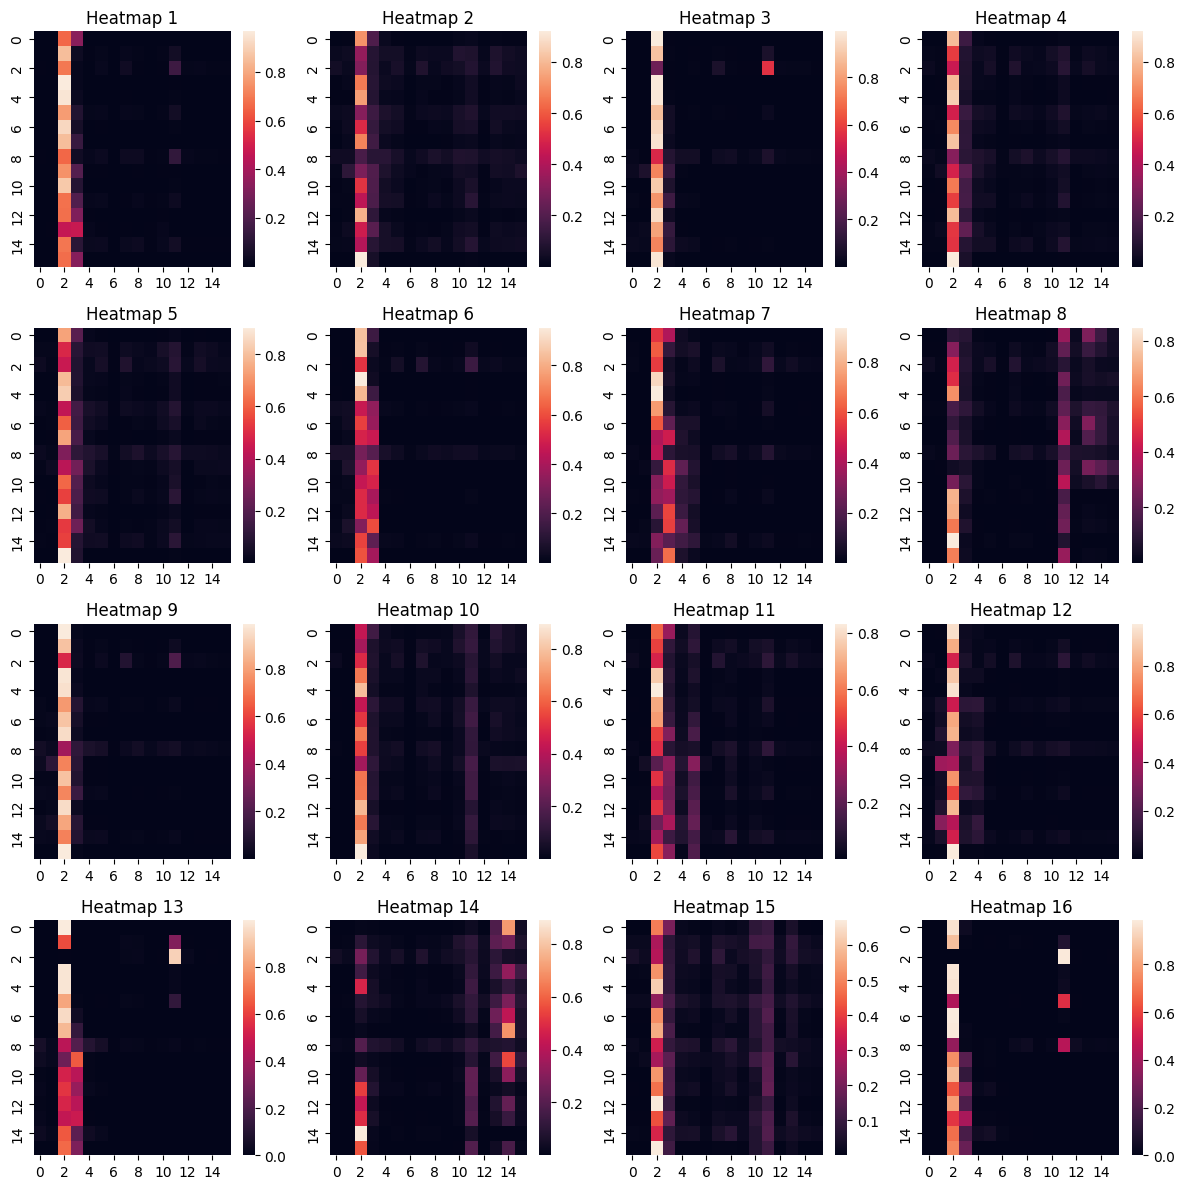

In [ ]:

macro_ex, _ = get_batch('eval')
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(12, 12))  # Grid size is 4x4

for i, ax in enumerate(axes.flatten()):
    mini_ex = macro_ex[i].unsqueeze(-1)
    emb = model.src_input_projection(mini_ex)
    pos = model.position_embedding_table(torch.arange(block_size_src, device=device))
    mini_ex = emb + pos
    keys = model.encoder_blocks[0].sa.heads[1].key(mini_ex)
    queries = model.encoder_blocks[0].sa.heads[1].query(mini_ex)
    wei = queries @ keys.transpose(-2,-1) * 8**-0.5
    wei = F.softmax(wei, dim=-1) # (B, T, T)
    wei = wei.cpu().detach().numpy()
    sns.heatmap(wei, ax=ax)  # Set heatmap color to orange
    ax.set_title(f'Heatmap {i+1}')

plt.tight_layout()
plt.show()

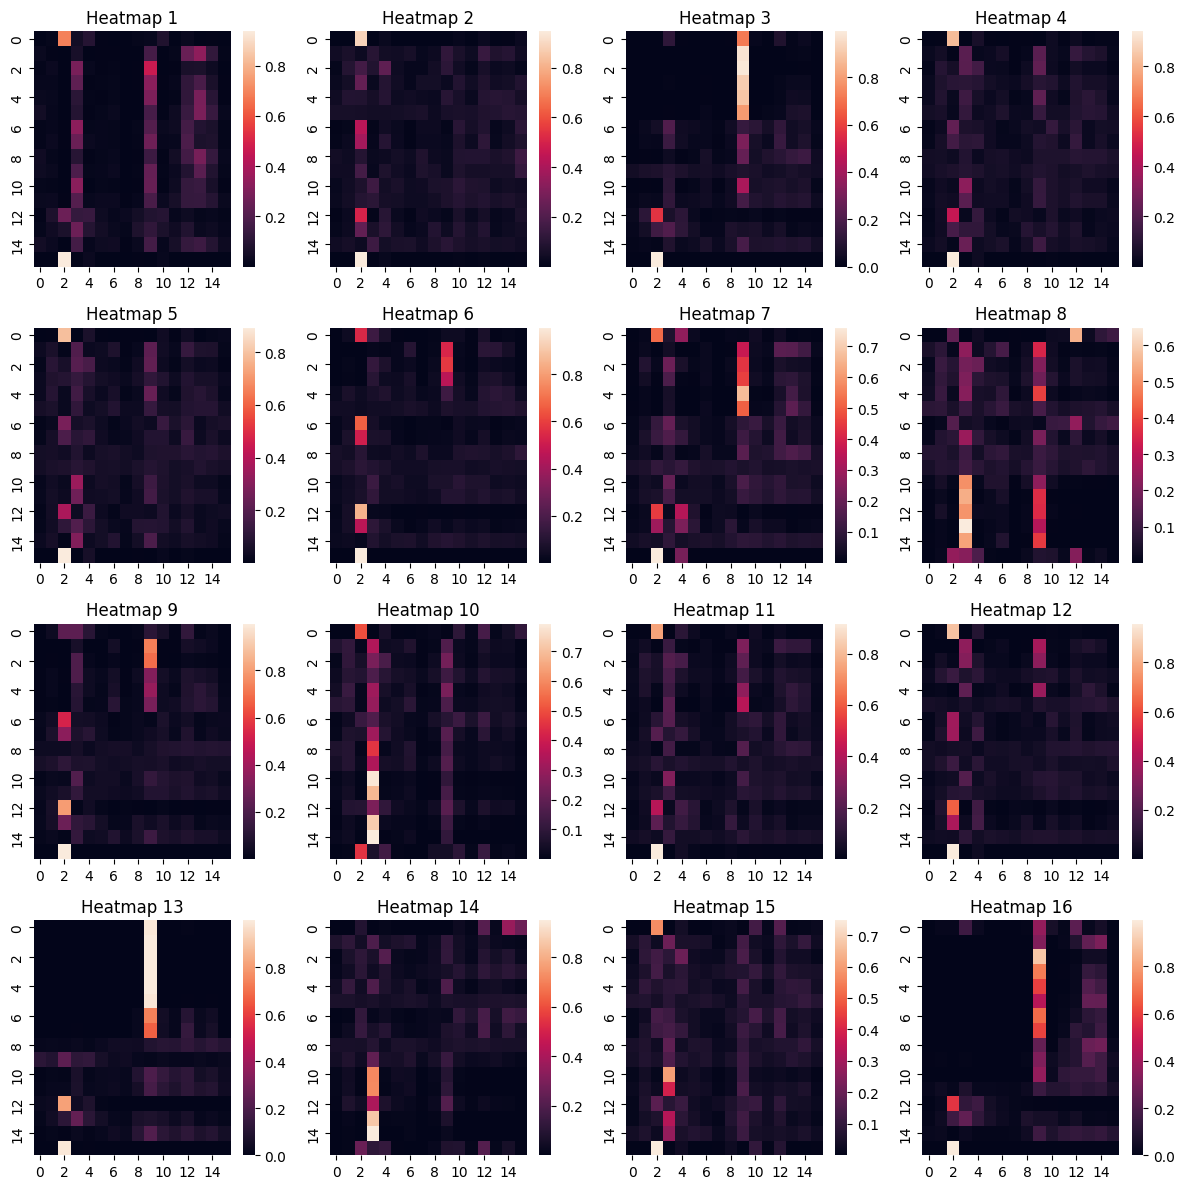

In [ ]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(12, 12))  # Grid size is 4x4
for i, ax in enumerate(axes.flatten()):
    mini_ex = macro_ex[i].unsqueeze(-1)
    emb = model.src_input_projection(mini_ex)
    pos = model.position_embedding_table(torch.arange(block_size_src, device=device))
    mini_ex = emb + pos
    keys = model.encoder_blocks[0].sa.heads[0].key(mini_ex)
    queries = model.encoder_blocks[0].sa.heads[0].query(mini_ex)
    wei = queries @ keys.transpose(-2,-1) * 8**-0.5
    wei = wei.cpu().detach()
    wei = F.softmax(wei, dim=-1) # (B, T, T)
    sns.heatmap(wei, ax=ax)  # Set heatmap color to orange
    ax.set_title(f'Heatmap {i+1}')

plt.tight_layout()
plt.show()

####Decoder self attention

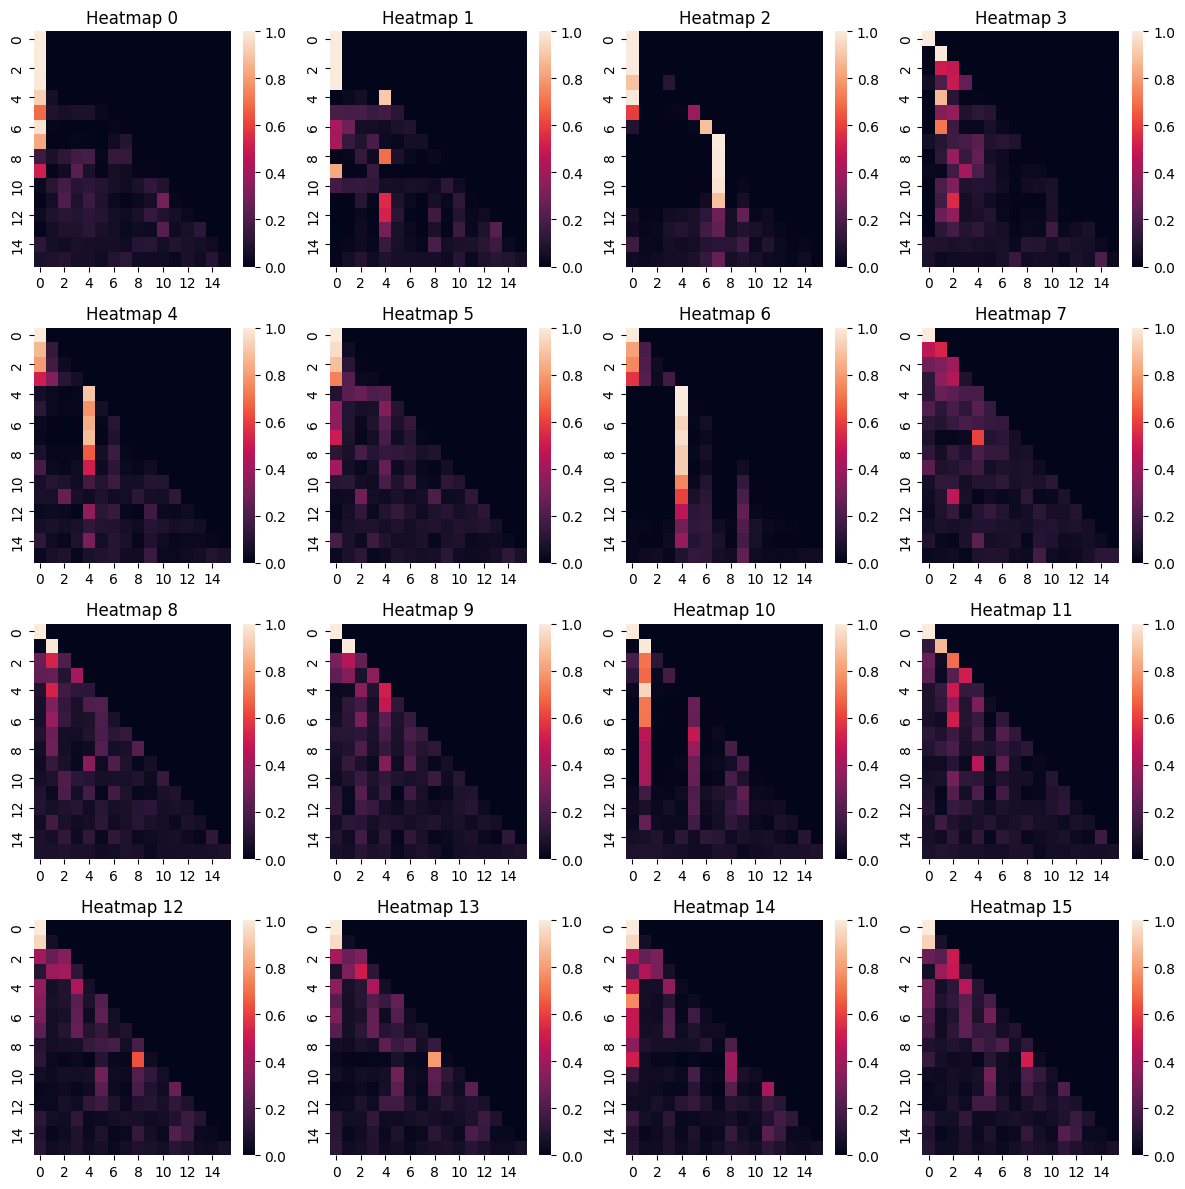

In [ ]:
macro_ex, _, _ = get_batch_en_de('eval')
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(12, 12))  # Grid size is 4x4

for i, ax in enumerate(axes.flatten()):
    mini_ex = macro_ex[i%4+4].unsqueeze(-1)
    emb = model.tgt_input_projection(mini_ex)
    pos = model.position_embedding_table(torch.arange(16, device=device))
    mini_ex = emb + pos
    keys = model.decoder_blocks[0].sa.heads[math.floor(i/4)].key(mini_ex)
    queries = model.decoder_blocks[0].sa.heads[math.floor(i/4)].query(mini_ex)
    wei = queries @ keys.transpose(-2,-1) * 8**-0.5
    wei = wei.cpu().detach()
    trill = torch.tril(torch.ones(block_size, block_size))
    wei = wei.masked_fill(trill[:16, :16] == 0, float('-inf'))
    wei = F.softmax(wei, dim=-1) # (B, T, T)
    sns.heatmap(wei, ax=ax)  # Set heatmap color to orange
    ax.set_title(f'Heatmap {i}')

plt.tight_layout()
plt.show()

##Might as well have some basis

###Time perceptron

In [ ]:
block_size = 16
eval_interval = 40
eval_iters = 200
max_iters = 5000
eval_interval = 100
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
batch_size = 32

In [ ]:
def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.tensor([data[i+block_size] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

In [ ]:
import pandas as pd
import torch
import torch.nn as nn
from torch.nn import functional as F
import math

class TimePerceptron(nn.Module):
  def __init__(self, input_dim, output_dim, hidden_dim, block_size):
    super().__init__()
    self.input_layer = nn.Linear(input_dim, hidden_dim)
    self.hidden_layer = nn.Linear(hidden_dim * block_size, hidden_dim)
    self.output_layer = nn.Linear(hidden_dim, output_dim)
    self.time_embedding = nn.Embedding(block_size, hidden_dim)

  def forward(self, x, y):
    #x is B,T
    B, T = x.shape
    input_emb = self.input_layer(x.unsqueeze(-1)) #B, T, hidden_dim
    pos_emb = self.time_embedding(torch.arange(T, device=device)) # (T,C)
    x = input_emb + pos_emb
    x = x.view(B, -1)
    x = F.relu(self.hidden_layer(x))
    preds = self.output_layer(x).squeeze(-1)

    if y is None:
      loss = None
    else:
      loss = F.mse_loss(preds, y)
    return preds, loss



####Influenza

In [ ]:
train_data, val_data = get_ili()
model = TimePerceptron(1, 1, 50, 16)
m = model.to(device)
# print the number of parameters in the model
print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')

# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)

for iter in range(5000):
    # every once in a while evaluate the loss on train and val sets
    if iter % 50 == 0 or iter == max_iters - 1:
        losses = estimate_loss()
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    # sample a batch of data
    tgt, tgt_y = get_batch('train')

    # evaluate the loss
    out, loss = model(tgt, tgt_y)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

0.041001 M parameters
step 0: train loss 8.2384, val loss 4.7174
step 50: train loss 4.5440, val loss 2.4398
step 100: train loss 2.7126, val loss 1.6691
step 150: train loss 1.9536, val loss 1.2128
step 200: train loss 1.6311, val loss 1.0460
step 250: train loss 1.5110, val loss 0.9215
step 300: train loss 1.2811, val loss 0.8465
step 350: train loss 1.1189, val loss 0.8240
step 400: train loss 1.2365, val loss 0.7853
step 450: train loss 1.0212, val loss 0.6323
step 500: train loss 0.9358, val loss 0.6591
step 550: train loss 0.8831, val loss 0.6324
step 600: train loss 0.9345, val loss 0.5495
step 650: train loss 0.8121, val loss 0.5987
step 700: train loss 0.7488, val loss 0.5412
step 750: train loss 0.7168, val loss 0.5660
step 800: train loss 0.7424, val loss 0.5258
step 850: train loss 0.7400, val loss 0.5194
step 900: train loss 0.7591, val loss 0.4937
step 950: train loss 0.7431, val loss 0.4785
step 1000: train loss 0.6585, val loss 0.4792
step 1050: train loss 0.6628, val l

####**IBM**


In [ ]:
# Read the CSV file using pandas
data_frame = pd.read_csv('ibm.csv')

print(data_frame.shape)
# Get the values from the first column as a NumPy array
column_values = data_frame.iloc[:, 1].values

# Convert the NumPy array to a Torch tensor
tensor = torch.tensor(column_values, dtype=torch.float32)

n = int(0.9*len(tensor)) # first 90% will be train, rest val
train_data = tensor[:n]
val_data = tensor[n:]

train_data = torch.nan_to_num(train_data, nan=torch.nanmean(train_data))
val_data = torch.nan_to_num(val_data, nan=torch.nanmean(train_data))

(3020, 7)


In [ ]:
model = TimePerceptron(1, 1, 50, 16)
m = model.to(device)
# print the number of parameters in the model
print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')

# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)

for iter in range(5000):
    # every once in a while evaluate the loss on train and val sets
    if iter % 50 == 0 or iter == max_iters - 1:
        losses = estimate_loss()
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    # sample a batch of data
    tgt, tgt_y = get_batch('train')

    # evaluate the loss
    out, loss = model(tgt, tgt_y)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

0.041001 M parameters
step 0: train loss 24352.9629, val loss 27172.3223
step 50: train loss 13818.4014, val loss 15610.0527
step 100: train loss 8624.3252, val loss 9614.7998
step 150: train loss 5473.6118, val loss 6116.9907
step 200: train loss 3473.2378, val loss 3888.0334
step 250: train loss 2067.6416, val loss 2313.4463
step 300: train loss 1173.2842, val loss 1310.5642
step 350: train loss 625.9003, val loss 684.1739
step 400: train loss 311.9267, val loss 341.6030
step 450: train loss 159.8374, val loss 172.4313
step 500: train loss 80.5075, val loss 83.0480
step 550: train loss 44.8875, val loss 43.4559
step 600: train loss 28.3514, val loss 27.7241
step 650: train loss 21.5324, val loss 21.4084
step 700: train loss 20.5558, val loss 18.9564
step 750: train loss 20.2347, val loss 18.8889
step 800: train loss 20.0923, val loss 18.2435
step 850: train loss 20.5194, val loss 18.6163
step 900: train loss 20.6393, val loss 18.1411
step 950: train loss 20.4201, val loss 18.7051
ste

###Linear Regression

In [ ]:
import sklearn as sk
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression


data_frame = pd.read_csv('ILI.csv')

data_frame.rename(columns={'Unnamed: 3':'ratio'}, inplace=True )
nonvalues = data_frame[data_frame['ratio']=='X'].index
data_frame.drop(nonvalues, inplace=True)
data_frame.iloc[:, 3] = pd.to_numeric(data_frame.iloc[:, 3])

y = np.array(pd.to_numeric(data_frame.iloc[:, 3])).reshape(-1, 1)
x = np.array(range(y.shape[0])).reshape(-1, 1)

y_train = y[:round(y.shape[0]*0.9)]
x_train = x[:round(y.shape[0]*0.9)]
y_test = y[round(y.shape[0]*0.9):]
x_test = x[round(y.shape[0]*0.9):]
lr = LinearRegression().fit(x_train, y_train)

pred = lr.predict(x_test)
mean_squared_error(y_test, pred)

<ipython-input-20-2e792aa3f609>:12: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data_frame.iloc[:, 3] = pd.to_numeric(data_frame.iloc[:, 3])


2.308568693069461